<div class="alert alert-block alert-info">
Section of the book chapter: <b>5.1 Supervised Learning Models</b>
</div>

# 3. Supervised learning

**Table of Contents**

* [3.1 Linear regression and partial least squares](#3.1-Linear-regression-and-partial-least-squares)
* [3.2 Tree-based Models](#3.2-Tree-based-Models)
* [3.3 Support Vector Machines](#3.3-Support-Vector-Machines)
* [3.4 k-Nearest Neighbors](#3.4-k-Nearest-Neighbors)
* [3.5 Artificial Neural Networks (ANN)](#3.5-Artificial-Neural-Networks,-ANN)
* [3.6 SUSI: Supervised Self-organizing Maps in Python](#3.6-SUSI:-Supervised-Self-organizing-Maps-in-Python)
* [3.7 Overall results](#3.7-Overall-results)

**Learnings:**

- how to implement different supervised machine learning models,
- how to plot regression results.



### Packages

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn.metrics as met
import datetime

import utils

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Read in Data

**Dataset:** Felix M. Riese and Sina Keller, "Hyperspectral benchmark dataset on soil moisture", Dataset, Zenodo, 2018. [DOI:10.5281/zenodo.1227836](http://doi.org/10.5281/zenodo.1227836) and [GitHub](https://github.com/felixriese/hyperspectral-soilmoisture-dataset)

**Introducing paper:** Felix M. Riese and Sina Keller, “Introducing a Framework of Self-Organizing Maps for Regression of Soil Moisture with Hyperspectral Data,” in IGARSS 2018 - 2018 IEEE International Geoscience and Remote Sensing Symposium, Valencia, Spain, 2018, pp. 6151-6154. [DOI:10.1109/IGARSS.2018.8517812](https://doi.org/10.1109/IGARSS.2018.8517812)

In [2]:
X_train, X_test, y_train, y_test = utils.get_xy_split()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(339, 125) (340, 125) (339,) (340,)


### Plot Configurations

In [3]:
norm = mpl.colors.Normalize(vmin=np.min([np.min(y_train), np.min(y_test)]),
                            vmax=np.max([np.max(y_train), np.max(y_test)]))
cmap = "cividis_r"

### Results Dataframe

In [4]:
results = pd.DataFrame(columns=["model", "r2", "mae", "rmse", "potential"])

### Metrics

The following functions calculate and print the following performance metrics:

* Coefficient of Determination $R^2$
* Mean Absolute Error (MEA)
* Root Mean Squared Error (RMSE)

In [5]:
def get_regression_metrics(y_pred):
    global y_test
    return (
        met.r2_score(y_test, y_pred),
        met.mean_absolute_error(y_test, y_pred),
        np.sqrt(met.mean_squared_error(y_test, y_pred)))

def print_regression_metrics(y_pred, model_name, potential):
    global results
    
    # get and print metrics
    r2, mae, rmse = get_regression_metrics(y_pred)
    print("R2 =   {0:.1f}% \nMAE =  {1:.2f} \nRMSE = {2:.2f}".format(
        r2*100, mae, rmse))
    
    # save metrics to dataframe
    if not ((results["model"]==model_name).any()):
        rdict = {
            "model": model_name,
            "r2": r2,
            "mae": mae,
            "rmse": rmse,
            "potential": potential}
        results = results.append(rdict, ignore_index=True)
        
    else:
        idx = results.index[results['model'] == model_name].tolist()[0]
        results.at[idx, "r2"] = r2
        results.at[idx, "mae"] = mae
        results.at[idx, "rmse"] = rmse
        results.at[idx, "potential"] = potential

### Fix Random State

In [6]:
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(43)

***

## 3.1 Linear regression and partial least squares

Content:

- [3.1.1 Linear regression](#3.1.1-Linear-regression)
- [3.1.2 Partial least squares](#3.1.2-Partial-least-squares)

### 3.1.1 Linear regression
Implementation: [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

R2 =   80.9% 
MAE =  1.19 
RMSE = 1.62


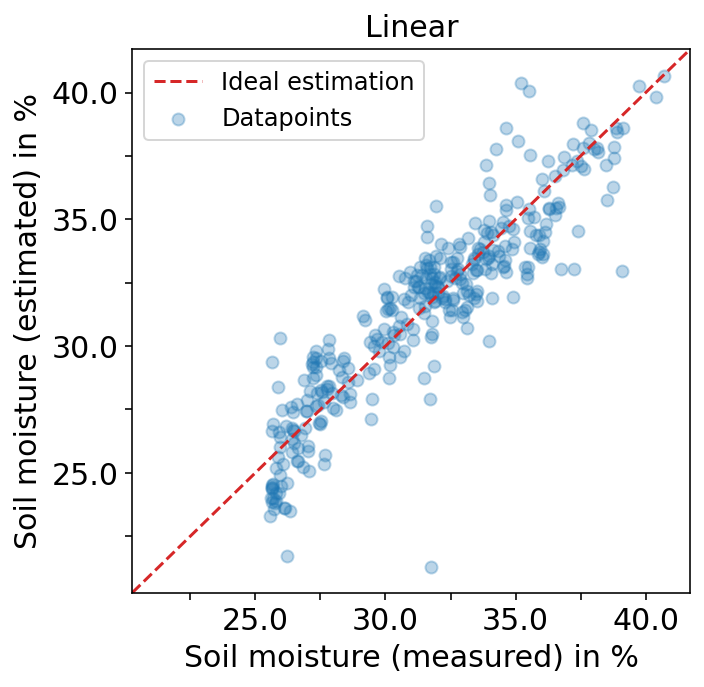

In [7]:
from sklearn.linear_model import LinearRegression

model_lin = LinearRegression()
model_lin.fit(X_train, y_train)
y_pred_lin = model_lin.predict(X_test)

print_regression_metrics(y_pred_lin, "Linear", "-")
utils.plot_regression_results(y_test, y_pred_lin, "Linear")

### 3.1.2 Partial least squares
Implementation: [sklearn.cross_decomposition.PLSRegression](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html)

R2 =   83.5% 
MAE =  1.16 
RMSE = 1.51


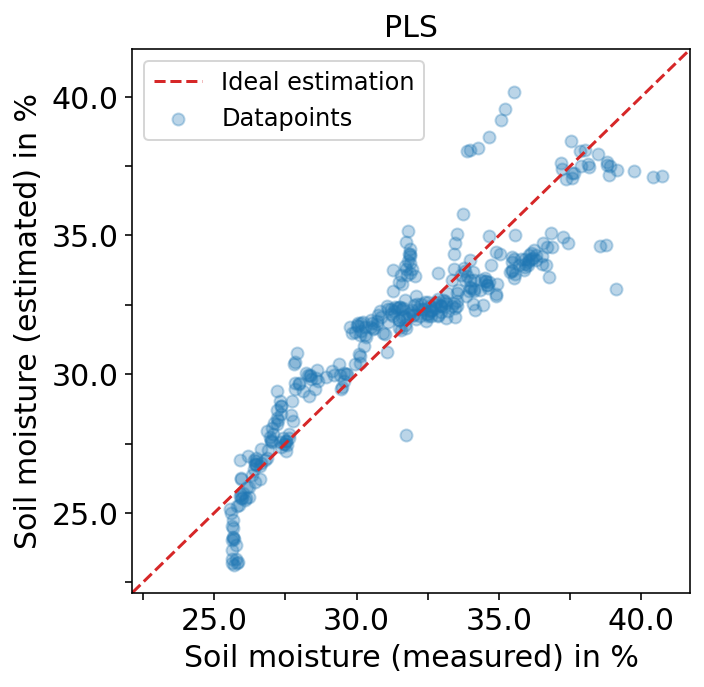

In [8]:
from sklearn.cross_decomposition import PLSRegression

model_pls = PLSRegression(n_components=5)
model_pls.fit(X_train, y_train)
y_pred_pls = model_pls.predict(X_test)

print_regression_metrics(y_pred_pls, "PLS", "Minor")
utils.plot_regression_results(y_test, y_pred_pls, "PLS")

***

## 3.2 Tree-based Models

Content:

- [3.2.1 Decision Tree](#3.2.1-Decision-Tree)
- [3.2.2 Bagging: Random Forest & Extremly Randomized Trees](#3.2.2-Bagging:-Random-Forest-&-Extremly-Randomized-Trees)
- [3.2.3 Boosting: Gradient Boosting](#3.2.3-Boosting:-Gradient-Boosting)

### 3.2.1 Decision Tree

**Source:** Breiman, L., Friedman, J., Olshen, R.A., Stone, C.J.: Classification and regression trees. Chapman and Hall/CRC (1984)

**Algorithm:**

The regression trees algorithm is defined as follows:
1. Start with the root node.
2. Start with the most significant feature of the training data.
3. Divide the input data with (binary) a cut $c_1$ on feature $x_i$, e.g. according to the Gini index, see below.
4. Divide data along the next best feature on cut $c_j$ for $j=2, 3, \ldots$
5. Stop if a condition is met, e.g. maximum number of nodes, maximum depth, maximum purity etc.
6. Every leaf is then averaged and therefore contains one output value.

The Gini index is defined as:

$G = 1 - \sum_{i=1}^n P_i^2 \qquad \text{with } P_i = \frac{N_i}{N},\label{eq:gini}$

with $N$ as number of all objects and $N_i$ as number of objects of class $i$.

**Implementation:** [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)

R2 =   92.2% 
MAE =  0.43 
RMSE = 1.04


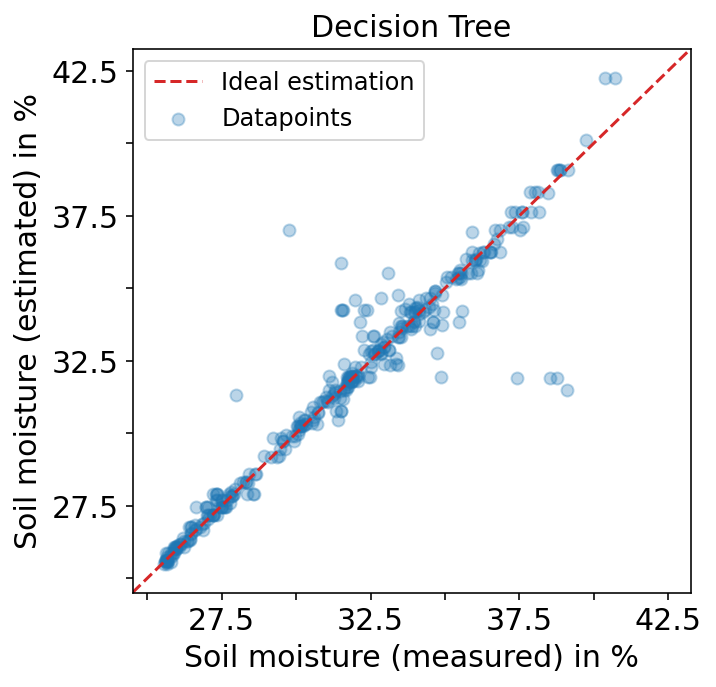

In [9]:
from sklearn.tree import DecisionTreeRegressor

model_dt = DecisionTreeRegressor()
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)

print_regression_metrics(y_pred_dt, "Decision Tree", "Minor")
utils.plot_regression_results(y_test, y_pred_dt, "Decision Tree")

### 3.2.2 Bagging: Random Forest & Extremly Randomized Trees
#### Random Forest
Implementation: [sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) 

R2 =   93.6% 
MAE =  0.45 
RMSE = 0.94
Out-of-bag estimate = 93.7%


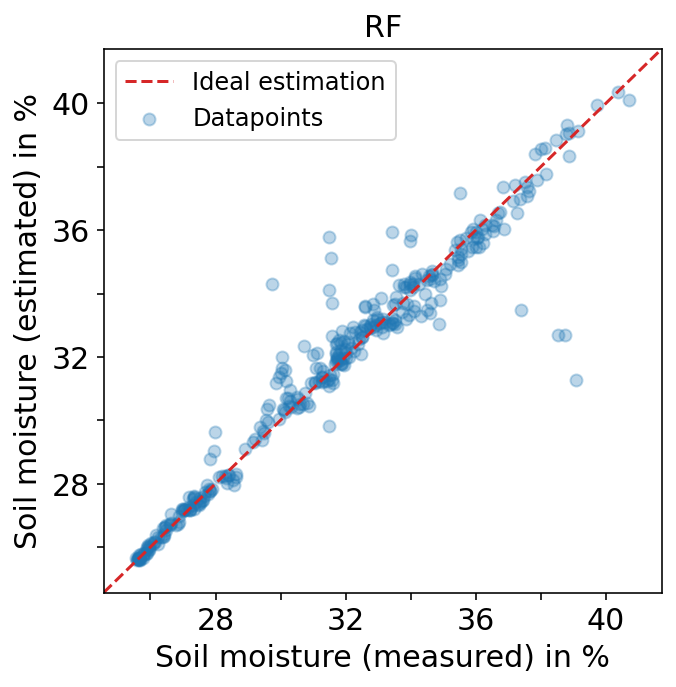

In [10]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=100, oob_score=True)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print_regression_metrics(y_pred_rf, "RF", "Minor")
utils.plot_regression_results(y_test, y_pred_rf, "RF")

print("Out-of-bag estimate = {0:.1f}%".format(model_rf.oob_score_*100))

#### Extremly Randomized Trees
Implementation: [sklearn.ensemble.ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor)

R2 =   96.7% 
MAE =  0.32 
RMSE = 0.67


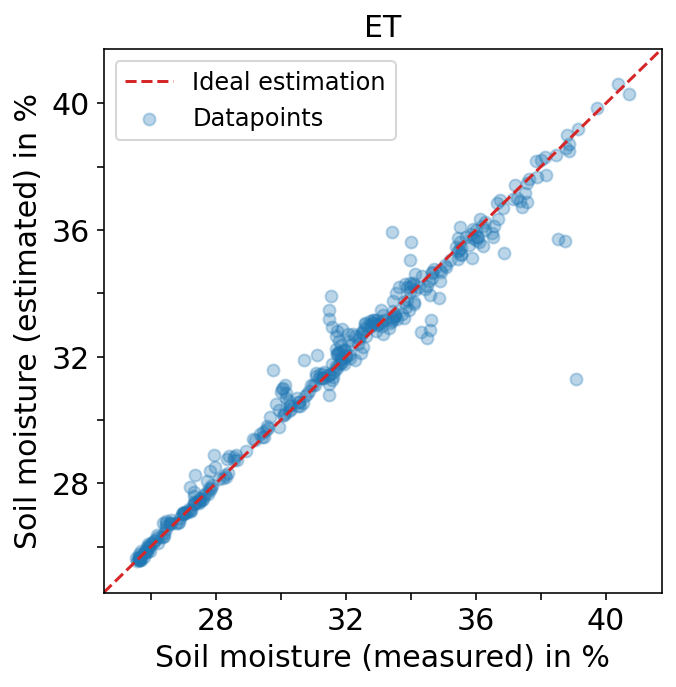

In [11]:
from sklearn.ensemble import ExtraTreesRegressor

model_et = ExtraTreesRegressor(n_estimators=100)
model_et.fit(X_train, y_train)
y_pred_et = model_et.predict(X_test)

print_regression_metrics(y_pred_et, "ET", "Minor")
utils.plot_regression_results(y_test, y_pred_et, "ET")

#### Feature Importance

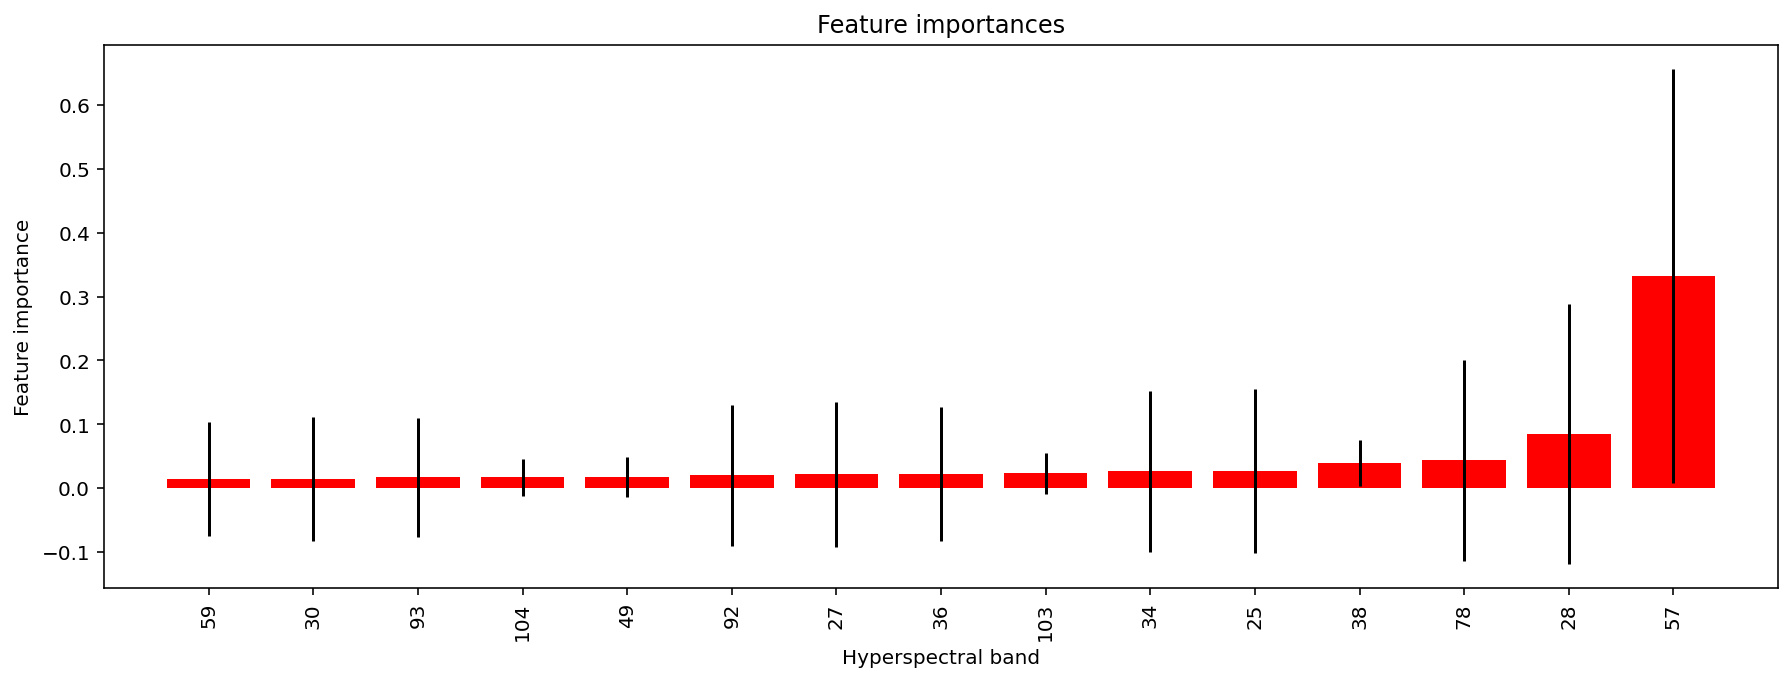

In [12]:
n_features_plotted = 15

importances = model_rf.feature_importances_
indices = np.argsort(importances)
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)
plt.figure(figsize=(15,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1])[125-n_features_plotted:], importances[indices][125-n_features_plotted:], color="r", yerr=std[indices][125-n_features_plotted:], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.xticks(range(X_train.shape[1])[125-n_features_plotted:], indices[:n_features_plotted], rotation=90)
plt.xlim([-1 + 125-n_features_plotted, X_train.shape[1]])
plt.xlabel("Hyperspectral band")
plt.ylabel("Feature importance")
plt.savefig("plots/featureimportance_rf.pdf", bbox_inches="tight")

### 3.2.3 Boosting: Gradient Boosting
Implementation: [sklearn.ensemble.GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)

R2 =   92.9% 
MAE =  0.50 
RMSE = 0.99


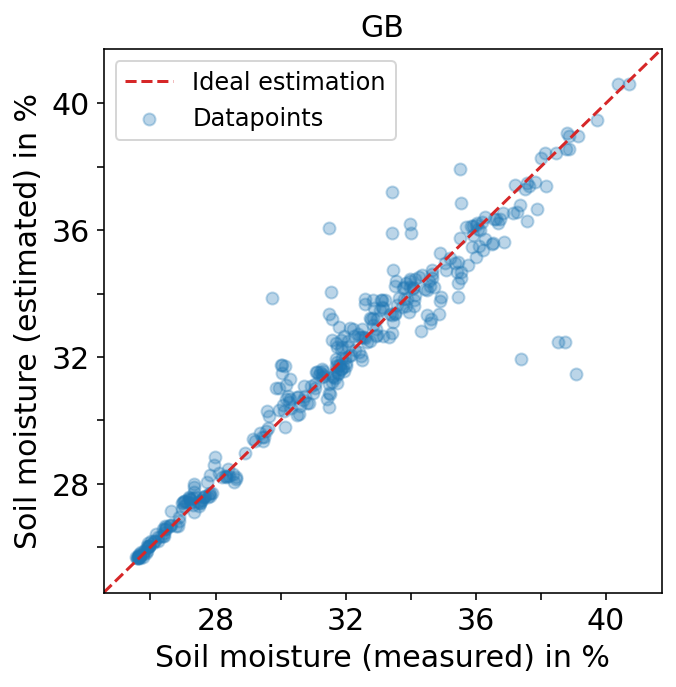

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)

print_regression_metrics(y_pred_gb, "GB", "Minor")
utils.plot_regression_results(y_test, y_pred_gb, "GB")

***

## 3.3 Support Vector Machines
Implementation: [sklearn.svm.SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

The SVM is tuned with a Grid Search, see [sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

R2 =   96.0% 
MAE =  0.37 
RMSE = 0.74


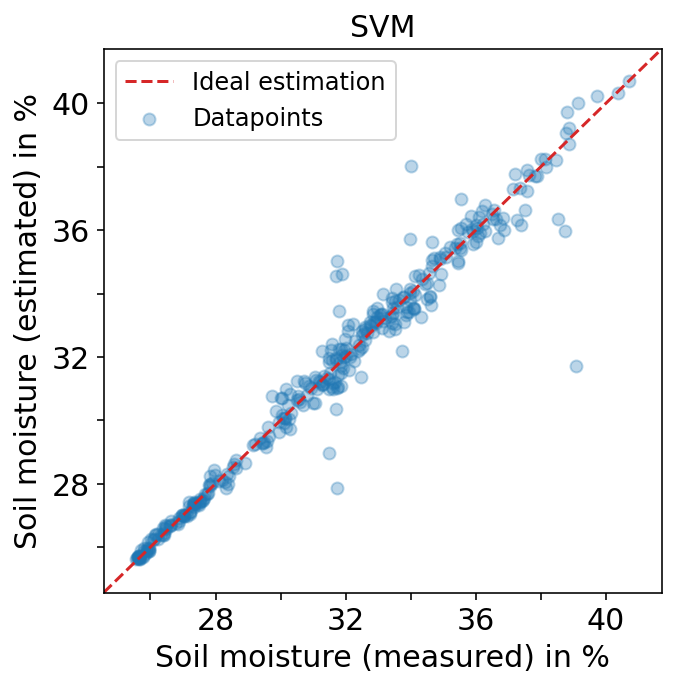

In [14]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

# 1. find hyperparameters
params = {"C": np.logspace(-8, 8, 17), "gamma": np.logspace(-8, 8, 17)}
rsearch = RandomizedSearchCV(
    estimator=SVR(),
    n_iter=30,
    cv=5,
    n_jobs=-1,
    param_distributions=params)
rsearch.fit(X_train, y_train)
model_svm = rsearch.best_estimator_

# 2. predict
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)

print_regression_metrics(y_pred_svm, "SVM", "Minor")
utils.plot_regression_results(y_test, y_pred_svm, "SVM")

***

## 3.4 k-Nearest Neighbors

Types:

- [3.4.1 Without weighting](#3.4.1-Without-weighting)
- [3.4.2 With distance weighting](#3.4.2-With-distance-weighting)

Implementation: [sklearn.neighbors.KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor)

### 3.4.1 Without weighting

R2 =   93.3% 
MAE =  0.43 
RMSE = 0.96


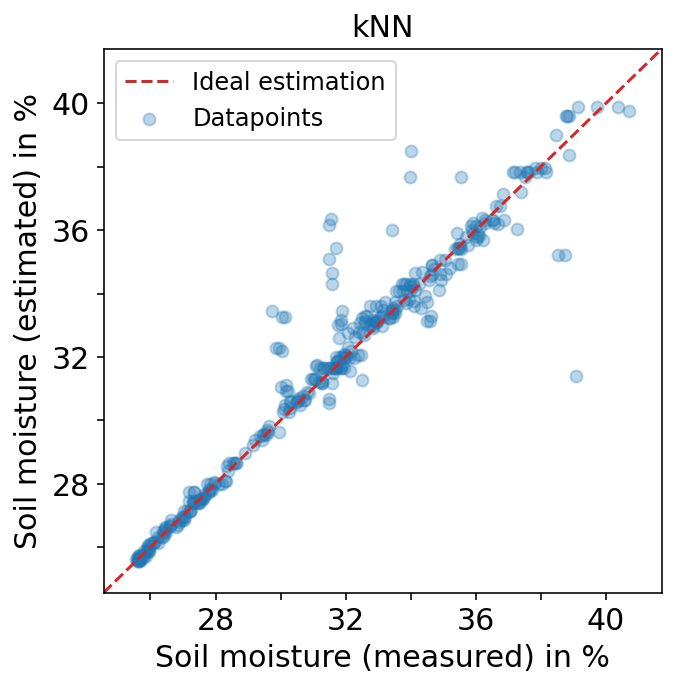

In [15]:
from sklearn.neighbors import KNeighborsRegressor

model_knn = KNeighborsRegressor(n_neighbors=5)
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)

print_regression_metrics(y_pred_knn, "k-NN", "Minor")
utils.plot_regression_results(y_test, y_pred_knn, "kNN")

### 3.4.2 With distance weighting

R2 =   94.5% 
MAE =  0.37 
RMSE = 0.87


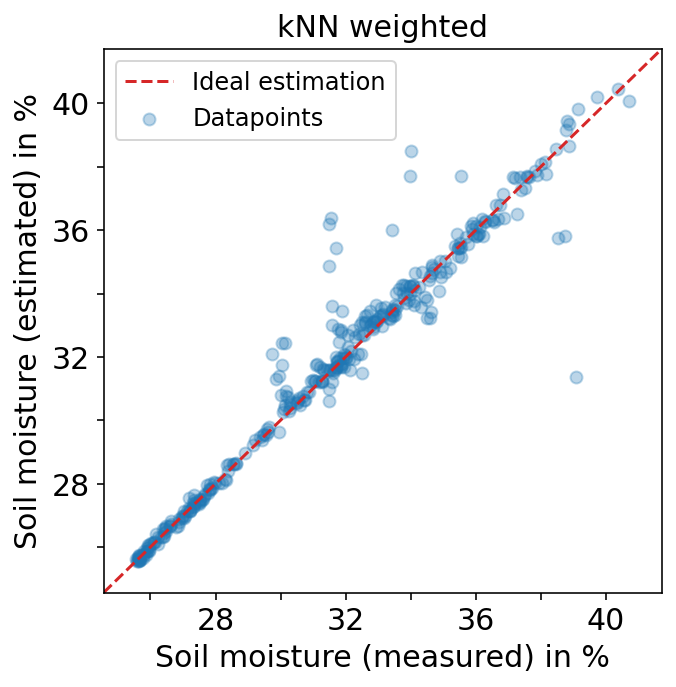

In [16]:
from sklearn.neighbors import KNeighborsRegressor

model_knnw = KNeighborsRegressor(n_neighbors=5, weights="distance")
model_knnw.fit(X_train, y_train)
y_pred_knnw = model_knnw.predict(X_test)

print_regression_metrics(y_pred_knnw, "k-NN (weighted)", "Minor")
utils.plot_regression_results(y_test, y_pred_knnw, "kNN weighted")

***

## 3.5 Artificial Neural Networks, ANN

Types:

- [3.5.1 Fully-connected ANNs](#3.5.1-Fully-connected-ANNs)
- [3.5.2 CNN with Keras and TensorFlow](#3.5.2-CNN-with-Keras-and-TensorFlow)

### 3.5.1 Fully-connected ANNs
#### scikit-learn
Implementation: [sklearn.neural_network.MLPRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)

R2 =   77.7% 
MAE =  1.27 
RMSE = 1.75


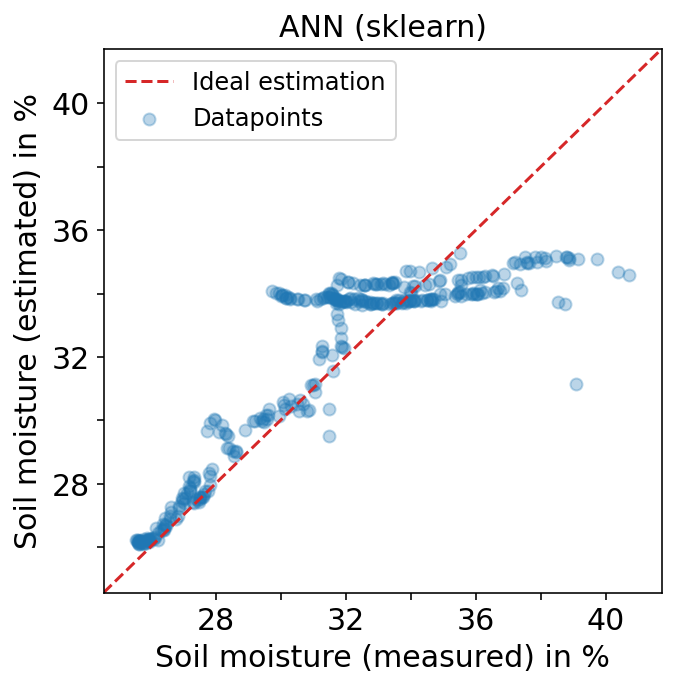

In [17]:
from sklearn.neural_network import MLPRegressor

model_ann = MLPRegressor(hidden_layer_sizes=(20, 20, 20), batch_size=10, max_iter=500)
model_ann.fit(X_train, y_train)
y_pred_ann = model_ann.predict(X_test)

print_regression_metrics(y_pred_ann, "ANN (sklearn)", "Major")
utils.plot_regression_results(y_test, y_pred_ann, "ANN (sklearn)")

#### Keras with TensorFlow

R2 =   75.8% 
MAE =  1.41 
RMSE = 1.82


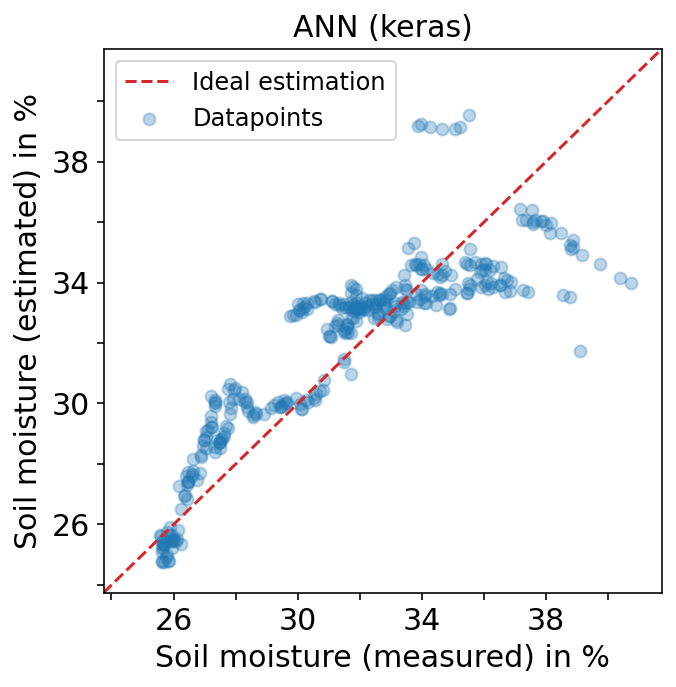

In [18]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

keras.backend.clear_session()

# define model
model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[1], activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="linear"))

# compile and train model
model.compile(loss="mean_squared_error", optimizer="nadam")
model.fit(X_train, y_train, epochs=1000, verbose=0, batch_size=10,
          validation_data=(X_test, y_test))
y_pred_annk = model.predict(X_test)

print_regression_metrics(y_pred_annk, "ANN (keras)", "Major")
utils.plot_regression_results(y_test, y_pred_annk, "ANN (keras)")

### 3.5.2 CNN with Keras and TensorFlow

R2 =   76.8% 
MAE =  1.29 
RMSE = 1.79


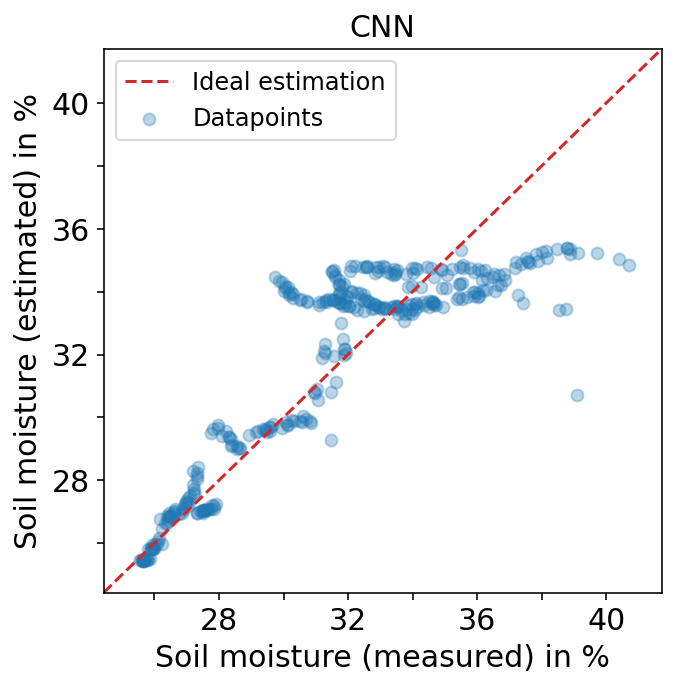

In [19]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten

keras.backend.clear_session()

# define model
model = Sequential()

model.add(Conv1D(filters=8, kernel_size=3, activation="relu",
                 input_shape=(X_train.shape[1],1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=16, kernel_size=3, activation="relu"))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(20, activation="relu"))
model.add(Dense(1, activation="linear"))

# compile and train model
model.compile(loss="mean_squared_error", optimizer="nadam")
model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train,
          epochs=500, verbose=0, batch_size=10,
          validation_data=(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test))
y_pred_cnn = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

print_regression_metrics(y_pred_cnn, "CNN", "Major")
utils.plot_regression_results(y_test, y_pred_cnn, "CNN")

***

## 3.6 SUSI: Supervised Self-organizing Maps in Python
Implementation: [felixriese/susi](https://github.com/felixriese/susi)

R2 =   92.8% 
MAE =  0.56 
RMSE = 0.99


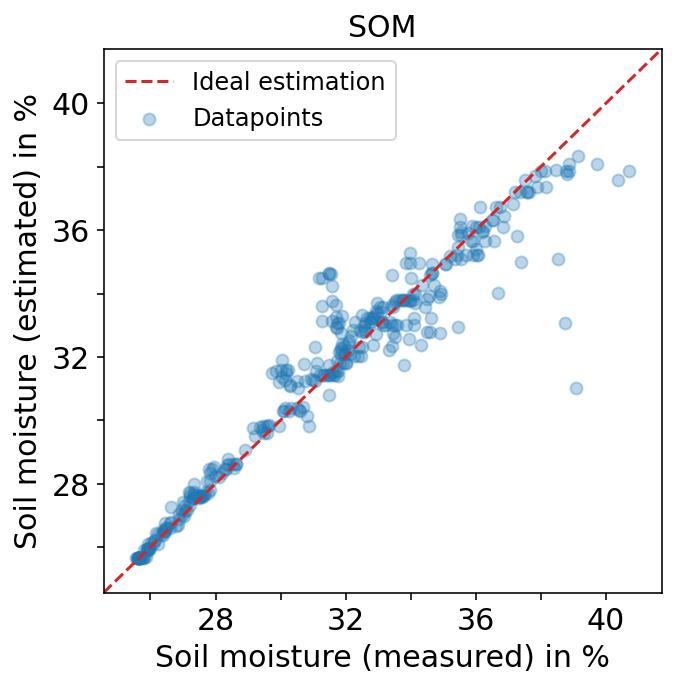

In [20]:
import susi

model_som = susi.SOMRegressor(
    n_rows=35,
    n_columns=35,
    n_iter_unsupervised=10000,
    n_iter_supervised=10000,
    n_jobs=-1)
model_som.fit(X_train, y_train)
y_pred_som = model_som.predict(X_test)

print_regression_metrics(y_pred_som, "SOM", "Minor")
utils.plot_regression_results(y_test, y_pred_som, "SOM")

***

## 3.7 Overall results

In [21]:
# save results to CSV
dt = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
results.to_csv("results/results_"+dt+".csv")

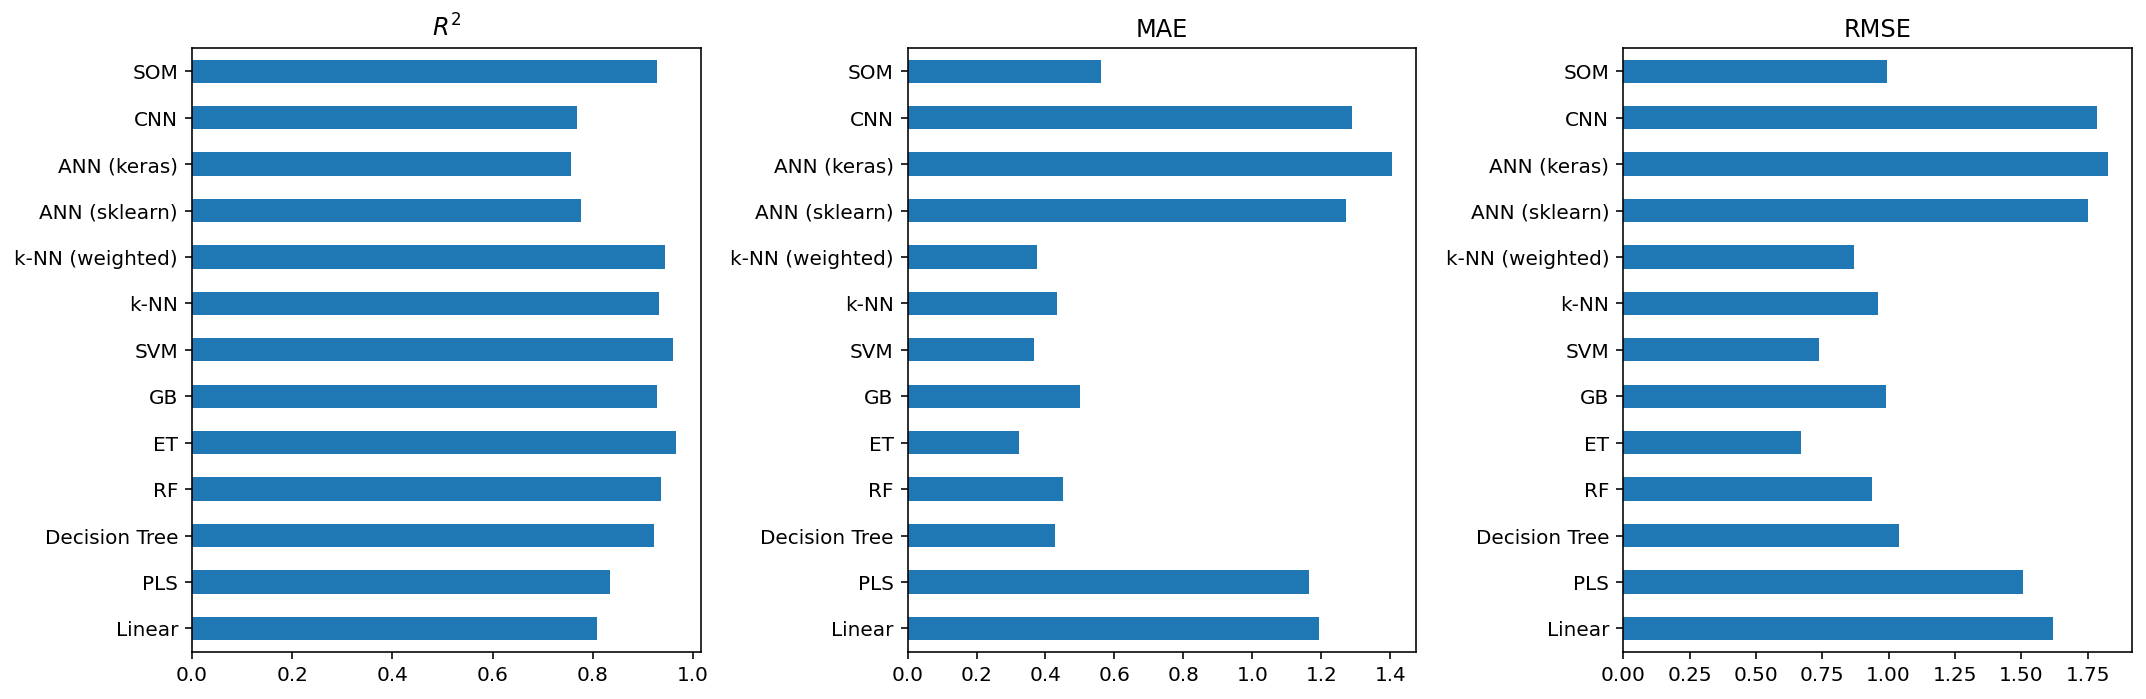

In [22]:
# plot horizontal bar plot for results
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

results.plot(x="model", y="r2", kind="barh", ax=ax1, title="$R^2$", legend=False)
results.plot(x="model", y="mae", kind="barh", ax=ax2, title="MAE", legend=False)
results.plot(x="model", y="rmse", kind="barh", ax=ax3, title="RMSE", legend=False)
for ax in [ax1, ax2, ax3]:
    ax.set_ylabel("")

plt.tight_layout()
plt.savefig("plots/results_bar.pdf", bbox_inches="tight")

In [23]:
# generate LaTeX table
utils.write_results_to_latex_table(results)